# Part 1: Saving and Loading Models

* 이번 실습에서는 model을 저장하고 불러오는 방법에 대해서 하겠습니다
* 저장과 불러오기를 학습하는 것이 중요한 이유는, 많은 경우 사전에 training이 완료된 모델을 불러와서 사용할 수있어야 하기 때문입니다
* 그럼 실습을 차근차근 해볼까요~


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import myhelper
import fc_model

#### `fc_model`
* 위에서 마지막 줄을 보시면 fc_model 이라는 모듈이 있습니다
* 실습의 편의상 제공하는 fc_model.py 파일안에 정의가 되어 있습니다 (한번 살펴보시죠) 
* 사용 방법 `fc_model(input_size, output_size, hidden_layers, drop_p=0.5)`
  * `input_size`는 input 벡터의 크기
  * `output_size`는 output 벡터의 크기
  * `hidden_layers` **list**로 hidden layer들의 크기를 저장합니다
    * 예를 들어서 `hidden_layers=[256, 128, 64]` 라 하면
    * hidden layer를 3개 각각 256, 128 64의 크기로 만들어 줍니다.
  * 즉 전체적으로 네트워크를 아래와 같이 구성합니다:
  ```
     hidden_1 = nn.Linear(input_size, 256)
     hidden_2 = nn.Linear(256, 128)
     hidden_3 = nn.Linear(128, output_size)
  ```
  * 모든 hidden layer의 activation은 `F.relu` 입니다
  * output layer의 activation 함수는 `F.log_softmax`를 적용합니다
  * 모든 hidden layer에 dropout을 `drop_p` 확률로 적용합니다

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

* 이미지 한개 샘플을 살펴봅니다 (이미 익숙한 그림입니다)

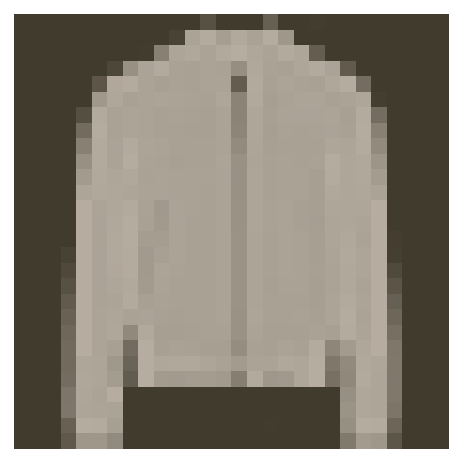

In [ ]:
image, label = next(iter(trainloader))
myhelper.imshow(image[0,:]);

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [ ]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.701..  Test Loss: 0.985..  Test Accuracy: 0.666
Epoch: 1/2..  Training Loss: 1.024..  Test Loss: 0.713..  Test Accuracy: 0.734
Epoch: 1/2..  Training Loss: 0.823..  Test Loss: 0.666..  Test Accuracy: 0.748
Epoch: 1/2..  Training Loss: 0.835..  Test Loss: 0.649..  Test Accuracy: 0.751
Epoch: 1/2..  Training Loss: 0.738..  Test Loss: 0.601..  Test Accuracy: 0.772
Epoch: 1/2..  Training Loss: 0.711..  Test Loss: 0.624..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.686..  Test Loss: 0.562..  Test Accuracy: 0.786
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.561..  Test Accuracy: 0.788
Epoch: 1/2..  Training Loss: 0.653..  Test Loss: 0.538..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.637..  Test Loss: 0.540..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.618..  Test Loss: 0.544..  Test Accuracy: 0.801
Epoch: 1/2..  Training Loss: 0.592..  Test Loss: 0.523..  Test Accuracy: 0.806
Epoch: 1/2..  Training Loss: 0.607..  Test Loss: 0.5

## Saving and loading networks

* 1차적으로 *저장하기*가 유용한 이유는 생각해보실 수 있죠? 우리가 training이 된 네트워크를 통해서 예측을 하고자 하는데, 매번 training을 할 수도, 이유도 없죠
* 대신에 training이 완료된 모델을 저장하고, 활용하고자 할때 불러와서 사용하면 유용하겠죠?
* Pytorch에서 우리가 training을 통해서 얻은 parameter들은 `state_dict`라는 형태로 자장됩니다
  * 즉 네트워크의 weight와 bias들이 각 layer 별로 저장됩니다. 아래 확인해보죠


In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [ ]:
model.state_dict()

OrderedDict([('hidden_layers.0.weight',
              tensor([[-0.0020,  0.0081, -0.0108,  ...,  0.0464,  0.0418,  0.0139],
                      [-0.0129, -0.0084,  0.0238,  ..., -0.0263,  0.0064, -0.0177],
                      [ 0.0226,  0.0616,  0.0441,  ...,  0.0254,  0.0684,  0.0248],
                      ...,
                      [ 0.0153,  0.0163, -0.0010,  ..., -0.0100,  0.0043, -0.0117],
                      [ 0.0081,  0.0317,  0.0391,  ..., -0.0102,  0.0412,  0.0303],
                      [ 0.0453,  0.0390,  0.0226,  ...,  0.0549,  0.0212,  0.0313]])),
             ('hidden_layers.0.bias',
              tensor([ 0.0185,  0.0036, -0.0575,  0.0081, -0.0528, -0.0367,  0.0118, -0.0148,
                      -0.0351, -0.0378, -0.0493, -0.0890, -0.0208,  0.0003, -0.0051, -0.0498,
                      -0.0128, -0.0621,  0.0070, -0.0110,  0.0055, -0.0666, -0.0290,  0.0176,
                      -0.0443, -0.0148, -0.0202, -0.0540, -0.0022, -0.0192, -0.0132,  0.0128,
            

* 위 state dictionary를 `torch.save`를 사용하여 저장하면 됩니다
* 예를 들어서 이름을 `checkpoint.pth`로 저장하도록 해보죠


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

* 위 저장된 state dict를 다시  `torch.load`를 통해서 불러올 수 있습니다

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


* 저장된 state dict를 모델이 적용하기 위해서는 다음과 같은 명령어를 사용합니다"
  * `model.load_state_dict(state_dict)`.

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

* 예고한 바와 같이 방법은 간단하죠?
* 하지만, 한가지 주의해야할 부분이 있습니다. 쉽게 생각해볼 수 있는데, 내가 저장된 state_dict를 적용하고자 하는 모델과, 저장된 네트워크의 parameter 수 가 맞지 않으면 에러가 납니다 (당연하겠죠?)
* 아래 예제를 살펴보죠


In [ ]:
# 저장한 네트워크와 구조를 다르게 새로운 모델을 생성합니다 원 구조는 hidden layer가 [512, 256, 128]였죠?
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: ignored

### 네트워크 구조를 함께 저장하기
* 요약하자면, 적용하고자하는 state_dict의 구조에 정확히 맞춰서 적용해야 한다는 뜻입니다
* 그렇다면, 저장하고자하는 네트워크의 구조도 함께 저장해두면 편리하겠죠?


In [ ]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

* 이제 원하는 모든 정보를 저장하였습니다
* 불러오기를 쉽게 하기 위해서, 저장 구조를 이해하고 불러오기 모듈을 작성해봅니다

## Exercise 1
아래 `load_checkpoint` 모듈을 완성하세요
  * 위에서 저장한 checkpoint dictionary를 `checkpoint`로 불러옵니다
  * 위에서 저장한 구조 정보를 활용하여 `model`을 완성하세요
  * `load_state_dict`를 사용하여 생성한 `model`에 training 된 parameter를 적용하세요

In [ ]:
def load_checkpoint(filepath):
    ############## 답 작성 ##############

    checkpoint = torch.load(filepath) # 파일을 불러옴
    model = fc_model.Network(checkpoint['input_size'], 
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    #checkpoint 딕셔너리의 input_size, output_size, hidden_layers를 fc_model.Network에 넣음
    model.load_state_dict(checkpoint['state_dict'])
    # checkpoint 자료구조의 state_dict를 불러서 load해서 state_dict에 load를 함
    #####################################
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Part 2: Transfer Learning

* Part 2에서는 이미 training이 잘된 네트워크를 불러와서 적용하는 방법을 실습하도록 하겠습니다
* '잘된 네트워크'는 여기서 [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html)에서 학습된 모델을 활용하도록 하겠습니다
* `ImageNet`은 14,000,000개의 image파일을 20,000개의 class로 분류되어있는 database 운영
  * 예를 들면 `딸기`, `풍선`등의 분류가 있으면, 각 분류별로 수백개의 image가 존재합니다
  * 각 이미지들은 수작업으로 labeling 되어있고, bounding box까지 표시가 되어 있습니다
  * 2010년 이후로 대회를 진행 ImageNet Large Scale Visual Recognition Challenge (ILSVRC)
    * 수천개의 class를 추려서 대회 진행
  * AlexNet과 그 이후: top-5 분류에서 15.3%로 혁신적 결과를 시작으로 deep learning 시대를 견인
    * GPU의 사용!
* 우리는 실제 사용하고자 하는 network를 직접 training 하는 경우보다, imagenet 등에서 매우 잘 동작하는 network을 적용하여, 부분적 학습을 통해서 사용하게 됩니다
* 본 실습에서는 imagenet에서 모델을 받아서 적용하는 방법을 알아보죠~


### Data 준비
* 위 Imagenet에서 사용된 자료는 다양한 class를 분류하는 작업을 수행합니다
* 이를 우리가 지난 시간에 받았던 `dog`, `cat`분류 문제에 적용하는 방법을 알아보도록 하겠습니다
* 자료 받은 것이 있다면, 본 경로에 복사하여 사용하거나, 아래 셀을 실행하여 자료를 받습니다

In [ ]:
from os.path import exists
from google_drive_downloader import GoogleDriveDownloader as gdd
import tarfile 

 
gdd.download_file_from_google_drive(file_id='1Glpk4kdbrs_mXJX8Nl71Mw4SfaFsl45u',
                                   dest_path = './Cat_Dog_data.tgz')

tf = tarfile.open("Cat_Dog_data.tgz")
tf.extractall()

### Loading Densenet121
* 본 실습을 위해서 우리는 [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5)을 활용하고자 합니다. 아래 불러오기와 구조를 살펴보죠

In [ ]:
from torchvision import models
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### densenet121의 구조

* 위에서 불러온 `densenet121`의 구조를 살펴보면 크게 두가지로 나눠집니다
  * (features) 부분과
  * (classifier) 부분으로 나눠집니다
* 위에서 (features) 부분은 매우 복잡한 layer들로 구성되어 있으며, 특별히, convolutional network으로 구성되어 있습니다. (이부분은 다음 시간부터 배우게 됩니다)
* 여기서 (features)에 해당하는 부분은 그대로 활용할 것이며, classifier에 대당하는 부분만 바꿔서 사용하고자 합니다
* 여기서 유념해야하는 부분은 classifier의 `output_feature=1000` 부분입니다
  * (classifier)는 fully-connected layer로
    * `(classifier): Linear(in_features=1024, out_features=1000)` 임
  * `output_feature=1000`는 분류는 1000가지로 수행하고 있는 네트워크라는 뜻입니다
  * 우리는 이부분을 2가지 dog, cat 중 한가지로 수행하도록 변경하고자 합니다
  
* 또한, densenet121은 입력 image가 224x224로 받습니다
* Densenet121에서 정규화한 값 또한 맞춰줘야 합니다 Densenet121의 경우는 
  * mean `[0.485, 0.456, 0.406]` and the standard deviations `[0.229, 0.224, 0.225]`로 학습되었습니다
* 위 정보에 맞춰서 우리 학습하고자 하는 IMAGE를 불러옵니다

In [ ]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## Transfer learning

* 위에서 가져온 densenet121의 네트워크에서 우리는 `classifier` 부분을 다시 우리 목적에 맞게 설계하고 다시 학습하고자 합니다 (이유는 영상에서 설명하도록 하겠습니다)

* 이때, densenet121에서 `feature` 부분은 다시 training 하지 않고 그대로 유지합니다. 이를 위해서 `feature`부분은 동결 (freeze)하고, 즉 backprop을 수행하지 않고, `classifier`부분만 수행합니다.

* 동결을 위해서 모든 `model.paramters()`의 `requires_grad = False` 로 바꿔줍니다
* 이후 classifier 부분을 덮어서 새로 구현하면, 이부분은 자동으로 gradient가 활성화 된 상태로 만들어지겠죠?

In [ ]:
# Backprop을 수행하지 않도록 parameter들을 동결시킴
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Cuda (GPU활용)

* dense121 처럼 좋은 성능의 네트워크는 많은 연산량을 요구하여 연산량이 많습니다
* 이를 가속화하기 위해서 pytorch는 GPU로 연산하는 방법을 제공합니다
* GPU에서 연산을 수행하면, CPU를 활용하는 것 보다 100배 이상 빠른 속도를 제공합니다
* 본 실습 docker 환경 및 nvidia gpu가 없는 경우는 GPU를 통한 연산 지원이 되지 않습니다
* 앞으로 실습에서 GPU를 활용하는 환경을 cloud에서 수행하는 방법을 설명하겠습니다
* 아래에서는 본 학습 영상을 위한 부분이니, 주석처리하시면 됩니다 (영상에서 효과 보시면 됩니다)


In [ ]:
import time

In [ ]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 3.938 seconds
Device = cuda; Time per batch: 0.008 seconds


## GPU 활용법

일반적으로 gpu를 활용하는 좋은 방법은 아래와 같은 줄을 추가하여 GPU가 있는 경우와 없는 경우를 분류합니다

```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# 이후 tensor나 모듈을 선언할때, 아래와 같이 수행합니다
input = data.to(device)
model = MyModule(...).to(device)
```

나머지 training 하는 방법은 기존과 똑같은 과정을 통해서 할 수 있습니다. 아래 실습을 해보죠.

>**Exercise 2:** 
cat, dog image를 transfer learning한 위 network를 활용하여 학습하세요. 가능하신 분들은 resnet을 통해서 학습을 수행해보세요. GPU가 없기 때문에 GPU학습은 불가하지만, 위 
`device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`
를 사용하여 gpu가 있다면, gpu 학습이 가능하도록 코드를 추가하세요.

* 최종적으로 다음과 같이 출력되도록 validation과 training을 수행하시면 됩니다 (지난 수업 참고)
```
Epoch 1/1.. Train loss: 0.835.. Test loss: 0.344.. Test accuracy: 0.841
Epoch 1/1.. Train loss: 0.480.. Test loss: 0.131.. Test accuracy: 0.966
Epoch 1/1.. Train loss: 0.361.. Test loss: 0.112.. Test accuracy: 0.969
Epoch 1/1.. Train loss: 0.225.. Test loss: 0.087.. Test accuracy: 0.974
Epoch 1/1.. Train loss: 0.222.. Test loss: 0.117.. Test accuracy: 0.955
Epoch 1/1.. Train loss: 0.231.. Test loss: 0.077.. Test accuracy: 0.973
Epoch 1/1.. Train loss: 0.196.. Test loss: 0.084.. Test accuracy: 0.968
Epoch 1/1.. Train loss: 0.180.. Test loss: 0.058.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.184.. Test loss: 0.066.. Test accuracy: 0.975
Epoch 1/1.. Train loss: 0.149.. Test loss: 0.063.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.204.. Test loss: 0.059.. Test accuracy: 0.977
Epoch 1/1.. Train loss: 0.193.. Test loss: 0.053.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.138.. Test loss: 0.057.. Test accuracy: 0.980
```

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
################## 답 작성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False # gradient 모두 끔

model.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()


optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

epochs = 1
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    #Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epoch}.."
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Teest accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

########################################################

Epoch 1/0..Train loss: 0.447.. Test loss: 0.090.. Teest accuracy: 0.966
Epoch 1/0..Train loss: 0.423.. Test loss: 0.166.. Teest accuracy: 0.941
Epoch 1/0..Train loss: 0.352.. Test loss: 0.127.. Teest accuracy: 0.949
Epoch 1/0..Train loss: 0.265.. Test loss: 0.067.. Teest accuracy: 0.975
Epoch 1/0..Train loss: 0.326.. Test loss: 0.051.. Teest accuracy: 0.982
Epoch 1/0..Train loss: 0.383.. Test loss: 0.092.. Teest accuracy: 0.962
Epoch 1/0..Train loss: 0.223.. Test loss: 0.081.. Teest accuracy: 0.976
Epoch 1/0..Train loss: 0.288.. Test loss: 0.090.. Teest accuracy: 0.963
Epoch 1/0..Train loss: 0.230.. Test loss: 0.088.. Teest accuracy: 0.973
Epoch 1/0..Train loss: 0.197.. Test loss: 0.063.. Teest accuracy: 0.975
Epoch 1/0..Train loss: 0.190.. Test loss: 0.054.. Teest accuracy: 0.979
Epoch 1/0..Train loss: 0.198.. Test loss: 0.055.. Teest accuracy: 0.982
Epoch 1/0..Train loss: 0.173.. Test loss: 0.064.. Teest accuracy: 0.975
Epoch 1/0..Train loss: 0.138.. Test loss: 0.047.. Teest accuracy